В цьому домашньому завданні ми знову працюємо з даними з нашого змагання ["Bank Customer Churn Prediction (DLU Course)"](https://www.kaggle.com/t/7c080c5d8ec64364a93cf4e8f880b6a0).

Тут ми побудуємо рішення задачі класифікації з використанням алгоритмів бустингу: XGBoost та LightGBM, а також використаємо бібліотеку HyperOpt для оптимізації гіперпараметрів.

0. Зчитайте дані `train.csv` в змінну `raw_df` та скористайтесь наведеним кодом нижче аби розділити дані на трнувальні та валідаційні і розділити дані на ознаки з матириці Х та цільову змінну. Назви змінних `train_inputs, train_targets, train_inputs, train_targets` можна змінити на ті, які Вам зручно.

  Наведений скрипт - частина отриманого мною скрипта для обробки даних. Ми тут не викнуємо масштабування та обробку категоріальних змінних, бо хочемо це делегувати алгоритмам, які будемо використовувати. Якщо щось не розумієте в наведених скриптах, рекомендую розібратись: навичка читати код - важлива складова роботи в машинному навчанні.

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from typing import Tuple, Dict, Any
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score


def split_train_val(df: pd.DataFrame, target_col: str, test_size: float = 0.2, random_state: int = 42) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Split the dataframe into training and validation sets.

    Args:
        df (pd.DataFrame): The raw dataframe.
        target_col (str): The target column for stratification.
        test_size (float): The proportion of the dataset to include in the validation split.
        random_state (int): Random state for reproducibility.

    Returns:
        Tuple[pd.DataFrame, pd.DataFrame]: Training and validation dataframes.
    """
    train_df, val_df = train_test_split(df, test_size=test_size, random_state=random_state, stratify=df[target_col])
    return train_df, val_df


def separate_inputs_targets(df: pd.DataFrame, input_cols: list, target_col: str) -> Tuple[pd.DataFrame, pd.Series]:
    """
    Separate inputs and targets from the dataframe.

    Args:
        df (pd.DataFrame): The dataframe.
        input_cols (list): List of input columns.
        target_col (str): Target column.

    Returns:
        Tuple[pd.DataFrame, pd.Series]: DataFrame of inputs and Series of targets.
    """
    inputs = df[input_cols].copy()
    targets = df[target_col].copy()
    return inputs, targets

In [7]:
raw_df = pd.read_csv('/content/drive/MyDrive/Data Science/train.csv', index_col=0)

In [8]:
 input_cols = raw_df.drop(columns=['Surname', 'Exited', 'CustomerId']).columns.tolist()
 target = 'Exited'

In [9]:
train_df, val_df = split_train_val(raw_df, target_col='Exited', test_size=0.2, random_state=42)

train_inputs, train_targets = separate_inputs_targets(train_df, input_cols=input_cols, target_col=target)
val_inputs, val_targets = separate_inputs_targets(val_df, input_cols=input_cols, target_col=target)


1. В тренувальному та валідаційному наборі перетворіть категоріальні ознаки на тип `category`. Можна це зробити двома способами:
 1. `df[col_name].astype('category')`, як було продемонстровано в лекції
 2. використовуючи метод `pd.Categorical(df[col_name])`

In [10]:
cat_features = train_inputs.select_dtypes(include='object').columns
train_inputs[cat_features] = train_inputs[cat_features].astype('category')
val_inputs[cat_features] = val_inputs[cat_features].astype('category')


2. Навчіть на отриманих даних модель `XGBoostClassifier`. Параметри алгоритму встановіть на свій розсуд, ми далі будемо їх тюнити. Рекомендую тренувати не дуже складну модель.

  Опис всіх конфігураційних параметрів XGBoostClassifier - тут https://xgboost.readthedocs.io/en/stable/parameter.html#global-config

  **Важливо:** зробіть такі налаштування `XGBoostClassifier` аби він самостійно обробляв незаповнені значення в даних і обробляв категоріальні колонки.

  Можна також, якщо працюєте в Google Colab, увімкнути можливість використання GPU (`Runtime -> Change runtime type -> T4 GPU`) і встановити параметр `device='cuda'` в `XGBoostClassifier` для пришвидшення тренування бустинг моделі.
  
  Після тренування моделі
  1. Виміряйте точність з допомогою AUROC на тренувальному та валідаційному наборах.
  2. Зробіть висновок про отриману модель: вона хороша/погана, чи є high bias/high variance?
  3. Порівняйте якість цієї моделі з тою, що ви отрмали з використанням DecisionTrees раніше. Чи вийшло покращити якість?

In [11]:
from xgboost import XGBClassifier

In [12]:
xgb_clf = XGBClassifier(
    max_depth=3,
    n_estimators=10,
    enable_categorical=True,  # для категорійних ознак
    use_label_encoder=False,  # щоб уникнути попереджень, якщо використовуєте нові версії XGBoost
    missing=np.nan,  # явне вказування пропущених значень
    device='cuda'
)

In [13]:
xgb_clf.fit(train_inputs, train_targets)

train_preds = xgb_clf.predict(train_inputs)
val_preds = xgb_clf.predict(val_inputs)

train_auc = roc_auc_score(train_targets, train_preds)
val_auc = roc_auc_score(val_targets, val_preds)

print(f'Train AUC: {train_auc}')
print(f'Validation AUC: {val_auc}')

Train AUC: 0.809116126912737
Validation AUC: 0.8095994238287948


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [23:03:40] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [23:03:40] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [23:03:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


**Висновок**:Модель має збалансовані показники на тренувальному і валідаційному наборах, що вказує на те, що вона добре узагальнює і не має високого bias або високої variance.Якщо порівнювати з результатами, отриманими з Decision Trees , XGBoost  показує нижчі результати.

3. Використовуючи бібліотеку `Hyperopt` і приклад пошуку гіперпараметрів для `XGBoostClassifier` з лекції знайдіть оптимальні значення гіперпараметрів `XGBoostClassifier` для нашої задачі. Задайте свою сітку гіперпараметрів виходячи з тих параметрів, які ви б хотіли перебрати. Поставте кількість раундів в підборі гіперпараметрів рівну **20**.

  **Увага!** Для того, аби скористатись hyperopt, нам треба задати функцію `objective`. В ній ми маємо задати loss - це може будь-яка метрика, але бажано використовувтаи ту, яка цільова в вашій задачі. Чим менший лосс - тим ліпша модель на думку hyperopt. Тож, тут нам треба задати loss - негативне значення AUROC. В лекції ми натомість використовували Accuracy.

  Після успішного завершення пошуку оптимальних гіперпараметрів
    - виведіть найкращі значення гіперпараметрів
    - створіть в окремій зміній `final_clf` модель `XGBoostClassifier` з найкращими гіперпараметрами
    - навчіть модель `final_clf`
    - оцініть якість моделі `final_clf` на тренувальній і валідаційній вибірках з допомогою AUROC.
    - зробіть висновок про якість моделі. Чи стала вона краще порівняно з попереднім пунктом (2) цього завдання?

In [14]:
!pip install hyperopt
import xgboost as xgb
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

In [15]:
def objective(params):
    clf = xgb.XGBClassifier(
        n_estimators=int(params['n_estimators']),
        learning_rate=params['learning_rate'],
        max_depth=int(params['max_depth']),
        min_child_weight=params['min_child_weight'],
        subsample=params['subsample'],
        colsample_bytree=params['colsample_bytree'],
        gamma=params['gamma'],
        reg_alpha=params['reg_alpha'],
        reg_lambda=params['reg_lambda'],
        enable_categorical=True,
        use_label_encoder=False,
        missing=np.nan,
        device='cuda',
        early_stopping_rounds=10
    )


    clf.fit(
        train_inputs,
        train_targets,
        eval_set=[(val_inputs, val_targets)],
        verbose=False
    )

    pred = clf.predict_proba(val_inputs)[:, 1]

    auc = roc_auc_score(val_targets, pred)

    return {'loss': -auc, 'status': STATUS_OK}

# Простір гіперпараметрів
space = {
    'n_estimators': hp.quniform('n_estimators', 50, 500, 25),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),
    'max_depth': hp.quniform('max_depth', 3, 15, 1),
    'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
    'subsample': hp.uniform('subsample', 0.5, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
    'gamma': hp.uniform('gamma', 0, 0.5),
    'reg_alpha': hp.uniform('reg_alpha', 0, 1),
    'reg_lambda': hp.uniform('reg_lambda', 0, 1)
}

# Оптимізація з використанням Hyperopt
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=20, trials=trials)

# Перетворення значень гіперпараметрів у кінцеві типи
best['n_estimators'] = int(best['n_estimators'])
best['max_depth'] = int(best['max_depth'])
best['min_child_weight'] = int(best['min_child_weight'])

print("Найкращі гіперпараметри: ", best)

# Навчання фінальної моделі з найкращими гіперпараметрами
final_clf = xgb.XGBClassifier(
    n_estimators=best['n_estimators'],
    learning_rate=best['learning_rate'],
    max_depth=best['max_depth'],
    min_child_weight=best['min_child_weight'],
    subsample=best['subsample'],
    colsample_bytree=best['colsample_bytree'],
    gamma=best['gamma'],
    reg_alpha=best['reg_alpha'],
    reg_lambda=best['reg_lambda'],
    enable_categorical=True,
    use_label_encoder=False,
    missing=np.nan,
    device='cuda',
)

# Навчання на тренувальному наборі
final_clf.fit(train_inputs, train_targets)

# Оцінка якості моделі на тренувальній та валідаційній вибірках
train_preds = final_clf.predict_proba(train_inputs)[:, 1]
val_preds = final_clf.predict_proba(val_inputs)[:, 1]

train_auc = roc_auc_score(train_targets, train_preds)
val_auc = roc_auc_score(val_targets, val_preds)

print(f'Train AUC: {train_auc}')
print(f'Validation AUC: {val_auc}')


  5%|▌         | 1/20 [00:00<00:03,  5.05trial/s, best loss: -0.9272480965772687]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [23:03:45] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [23:03:45] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [23:03:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [23:03:45] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [23:03:45] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.

 10%|█         | 2/20 [00:00<00:06,  2.95trial/s, best loss: -0.9344087385966116]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [23:03:46] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [23:03:46] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [23:03:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 15%|█▌        | 3/20 [00:02<00:20,  1.19s/trial, best loss: -0.9344087385966116]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [23:03:48] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [23:03:48] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [23:03:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 20%|██        | 4/20 [00:10<00:57,  3.61s/trial, best loss: -0.9344087385966116]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [23:03:55] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [23:03:55] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [23:03:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 25%|██▌       | 5/20 [00:13<00:54,  3.62s/trial, best loss: -0.9346573839083614]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [23:03:59] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [23:03:59] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [23:03:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 30%|███       | 6/20 [00:16<00:47,  3.37s/trial, best loss: -0.9346573839083614]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [23:04:02] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [23:04:02] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [23:04:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 35%|███▌      | 7/20 [00:18<00:35,  2.72s/trial, best loss: -0.9346573839083614]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [23:04:03] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [23:04:03] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [23:04:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 40%|████      | 8/20 [00:29<01:04,  5.42s/trial, best loss: -0.9346573839083614]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [23:04:15] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [23:04:15] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [23:04:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 50%|█████     | 10/20 [00:33<00:35,  3.57s/trial, best loss: -0.9362991288840112]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [23:04:19] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [23:04:19] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [23:04:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [23:04:19] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [23:04:19] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.

 60%|██████    | 12/20 [00:34<00:15,  1.94s/trial, best loss: -0.9362991288840112]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [23:04:20] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [23:04:20] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [23:04:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [23:04:20] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [23:04:20] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.

 65%|██████▌   | 13/20 [00:35<00:10,  1.46s/trial, best loss: -0.9362991288840112]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [23:04:20] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [23:04:20] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [23:04:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 70%|███████   | 14/20 [00:37<00:10,  1.78s/trial, best loss: -0.9362991288840112]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [23:04:23] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [23:04:23] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [23:04:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 80%|████████  | 16/20 [00:39<00:05,  1.27s/trial, best loss: -0.9362991288840112]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [23:04:24] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [23:04:24] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [23:04:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 85%|████████▌ | 17/20 [00:39<00:02,  1.05trial/s, best loss: -0.9362991288840112]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [23:04:25] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [23:04:25] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [23:04:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [23:04:25] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)



 90%|█████████ | 18/20 [00:39<00:01,  1.37trial/s, best loss: -0.9362991288840112]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [23:04:25] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [23:04:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 95%|█████████▌| 19/20 [00:40<00:00,  1.69trial/s, best loss: -0.9370683860347075]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [23:04:25] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [23:04:25] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [23:04:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [23:04:25] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [23:04:25] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.

100%|██████████| 20/20 [00:40<00:00,  2.01s/trial, best loss: -0.9370683860347075]
Найкращі гіперпараметри:  {'colsample_bytree': 0.8342171541061549, 'gamma': 0.12860423667983834, 'learning_rate': 0.24532341227402016, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'reg_alpha': 0.9306132239308422, 'reg_lambda': 0.8522718730130778, 'subsample': 0.849630977328937}
Train AUC: 0.951413920340474
Validation AUC: 0.9335417381164689


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [23:04:25] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [23:04:25] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [23:04:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


###  Висновок: модель стала краще порівняно з попередньою! і навіть деревом прийняття рішень.

4. Навчіть на наших даних модель LightGBM. Параметри алгоритму встановіть на свій розсуд, ми далі будемо їх тюнити. Рекомендую тренувати не дуже складну модель.

  Опис всіх конфігураційних параметрів LightGBM - тут https://lightgbm.readthedocs.io/en/latest/Parameters.html

  **Важливо:** зробіть такі налаштування LightGBM аби він самостійно обробляв незаповнені значення в даних і обробляв категоріальні колонки.

  Аби передати категоріальні колонки в LightGBM - необхідно виявити їх індекси і передати в параметрі `cat_feature=cat_feature_indexes`

  Після тренування моделі
  1. Виміряйте точність з допомогою AUROC на тренувальному та валідаційному наборах.
  2. Зробіть висновок про отриману модель: вона хороша/погана, чи є high bias/high variance?
  3. Порівняйте якість цієї моделі з тою, що ви отрмали з використанням XGBoostClassifier раніше. Чи вийшло покращити якість?

In [16]:
import lightgbm as lgb

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [17]:
cat_feature_indexes = [train_inputs.columns.get_loc(col) for col in cat_features]

In [18]:
# Створення і налаштування моделі LightGBM
lgb_clf = lgb.LGBMClassifier(
    max_depth=3,
    n_estimators=100,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    missing=np.nan,  # Для обробки пропущених значень
    cat_feature=cat_feature_indexes  # Для обробки категоріальних ознак
)

lgb_clf.fit(train_inputs,train_targets, eval_set=[(val_inputs, val_targets)])


train_preds = lgb_clf.predict_proba(train_inputs)[:, 1]
val_preds = lgb_clf.predict_proba(val_inputs)[:, 1]

train_auc = roc_auc_score(train_targets, train_preds)
val_auc = roc_auc_score(val_targets, val_preds)

print(f'Train AUC: {train_auc}')
print(f'Validation AUC: {val_auc}')


[LightGBM] [Warning] Unknown parameter: missing
[LightGBM] [Warning] categorical_feature is set with cat_feature=1,2, categorical_column=1,2 will be ignored. Current value: categorical_feature=1,2
[LightGBM] [Warning] Unknown parameter: missing
[LightGBM] [Info] Number of positive: 2442, number of negative: 9558
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001994 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 843
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 10
[LightGBM] [Warning] Unknown parameter: missing
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.203500 -> initscore=-1.364561
[LightGBM] [Info] Start training from score -1.364561
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

5. Використовуючи бібліотеку `Hyperopt` і приклад пошуку гіперпараметрів для `LightGBM` з лекції знайдіть оптимальні значення гіперпараметрів `LightGBM` для нашої задачі. Задайте свою сітку гіперпараметрів виходячи з тих параметрів, які ви б хотіли перебрати. Поставте кількість раундів в підборі гіперпараметрів рівну **10**.

  **Увага!** Для того, аби скористатись hyperopt, нам треба задати функцію `objective`. І тут ми також ставимо loss - негативне значення AUROC, як і при пошуці гіперпараметрів для XGBoost. До речі, можна спробувати написати код так, аби в objective передавати лише модель і не писати схожий код двічі :)

  Після успішного завершення пошуку оптимальних гіперпараметрів
    - виведіть найкращі значення гіперпараметрів
    - створіть в окремій зміній `final_lgb_clf` модель `LightGBM` з найкращими гіперпараметрами
    - навчіть модель `final_lgb_clf`
    - оцініть якість моделі `final_lgb_clf` на тренувальній і валідаційній вибірках з допомогою AUROC.
    - зробіть висновок про якість моделі. Чи стала вона краще порівняно з попереднім пунктом (4) цього завдання?

In [19]:
def objective(params):
    clf = lgb.LGBMClassifier(
        n_estimators=int(params['n_estimators']),  # Кількість дерев у ансамблі (кількість ітерацій бустингу)
        learning_rate=params['learning_rate'],  # Коефіцієнт, на який зменшується внесок кожного доданого дерева
        max_depth=int(params['max_depth']),  # Максимальна глибина кожного дерева
        num_leaves=int(params['num_leaves']),  # Максимальна кількість листків, що дозволяємо кожному дереву мати.
        min_child_weight=params['min_child_weight'],  # Мінімальна сума ваг всіх вибірок, необхідна в кінцевому вузлі
        subsample=params['subsample'],  # Частка вибірок, що використовуються для побудови кожного дерева
        colsample_bytree=params['colsample_bytree'],  # Частка ознак, що використовуються при побудові кожного дерева
        reg_alpha=params['reg_alpha'],  # Параметр регуляризації L1 (Lasso)
        reg_lambda=params['reg_lambda'],  # Параметр регуляризації L2 (Ridge)
        min_split_gain=params['min_split_gain'],  # Мінімальне зменшення втрат, необхідне для виконання поділу
        cat_feature=cat_feature_indexes  # Індекси категорійних ознак
    )

    clf.fit(train_inputs, train_targets,
        eval_set=[(val_inputs, val_targets)],
        eval_metric='auc'
    )

    pred = clf.predict_proba(val_inputs)[:, 1]
    auc = roc_auc_score(val_targets, pred)

    return {'loss': -auc, 'status': STATUS_OK}

# Простір гіперпараметрів
space = {
    'n_estimators': hp.quniform('n_estimators', 50, 500, 25),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),
    'max_depth': hp.quniform('max_depth', 3, 15, 1),
    'num_leaves': hp.quniform('num_leaves', 20, 150, 1),
    'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
    'subsample': hp.uniform('subsample', 0.5, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
    'reg_alpha': hp.uniform('reg_alpha', 0, 1),
    'reg_lambda': hp.uniform('reg_lambda', 0, 1),
    'min_split_gain': hp.uniform('min_split_gain', 0, 0.1)  # додано мінімальне зменшення втрат для поділу
}

# Оптимізація
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=10, trials=trials)

# Перетворення значень гіперпараметрів у кінцеві типи
best['n_estimators'] = int(best['n_estimators'])
best['max_depth'] = int(best['max_depth'])
best['num_leaves'] = int(best['num_leaves'])
best['min_child_weight'] = int(best['min_child_weight'])

print("Найкращі гіперпараметри: ", best)

# Навчання фінальної моделі з найкращими гіперпараметрами
final_lgb_clf = lgb.LGBMClassifier(
    n_estimators=best['n_estimators'],
    learning_rate=best['learning_rate'],
    max_depth=best['max_depth'],
    num_leaves=best['num_leaves'],
    min_child_weight=best['min_child_weight'],
    subsample=best['subsample'],
    colsample_bytree=best['colsample_bytree'],
    reg_alpha=best['reg_alpha'],
    reg_lambda=best['reg_lambda'],
    min_split_gain=best['min_split_gain'],
    cat_feature=cat_feature_indexes,
    missing=np.nan
)
final_lgb_clf.fit(train_inputs, train_targets, eval_set=[(val_inputs, val_targets)], eval_metric='auc')
train_preds = final_lgb_clf.predict_proba(train_inputs)[:, 1]
val_preds = final_lgb_clf.predict_proba(val_inputs)[:, 1]

train_auc = roc_auc_score(train_targets, train_preds)
val_auc = roc_auc_score(val_targets, val_preds)

print(f'Train AUC: {train_auc}')
print(f'Validation AUC: {val_auc}')

[LightGBM] [Warning] categorical_feature is set with cat_feature=1,2, categorical_column=1,2 will be ignored. Current value: categorical_feature=1,2
[LightGBM] [Info] Number of positive: 2442, number of negative: 9558
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002233 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 843
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.203500 -> initscore=-1.364561
[LightGBM] [Info] Start training from score -1.364561
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

 В пункті 4 показник auc  був на 0.2 вище ( 93.5), проте модель має дуже високі параметри як на тренувальних так і на валідаційних даних.

6. Оберіть модель з експериментів в цьому ДЗ і зробіть новий `submission` на Kaggle та додайте код для цього і скріншот скора на публічному лідерборді.
  
  **Напишіть коментар, чому ви обрали саме цю модель?**

  І я вас вітаю - це останнє завдання з цим набором даних 💪 На цьому етапі корисно проаналізувати, які моделі показали себе найкраще і подумати, чому.

In [22]:
test_data = pd.read_csv('/content/drive/MyDrive/Data Science/test.csv')


input_cols = ['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']

cat_features = ['Geography', 'Gender']
test_data[cat_features] = test_data[cat_features].astype('category')


for col in cat_features:
    test_data[col] = test_data[col].cat.set_categories(train_inputs[col].cat.categories)


test_inputs = test_data[input_cols]


test_preds = final_lgb_clf.predict_proba(test_inputs)[:, 1]

submission_df = pd.DataFrame({'Id': test_data.index, 'Exited': test_preds})


sample_submission_df=pd.read_csv('/content/drive/MyDrive/Data Science/sample_submission.csv')


sample_submission_df['Exited']=submission_df['Exited']


sample_submission_df.to_csv('submission_boosting.csv', index=False)

[LightGBM] [Warning] Unknown parameter: missing


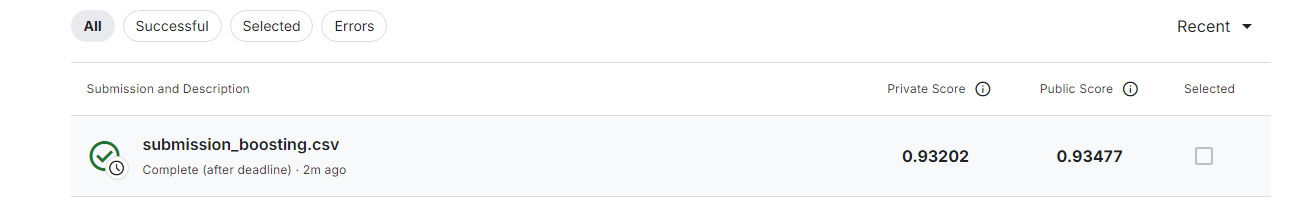

 Обрала модель final_lgb_clf   з останнього завдання, мені здається що так як вона пройшла тюнинг-вона має гарно справитись з новими даними, що і підтвердилось на кагл. Ця модель дала найкращі результати поміж всіма іншими.